In [ ]:
import jax.numpy as np
from jax.scipy.stats.norm import cdf,pdf,ppf
from jax import vmap,jit
import matplotlib.pyplot as plt
from jax.lax import cond,scan,while_loop
from functools import partial


def db_while_loop(cond_func,body_func,init_val):
    """
    A native python implementation of the accelerated JAX while_loop
    """
    val = init_val
    while cond_func(val):
        val = body_func(val)
    return val


@partial(jit,static_argnums = (0,-1))
def bisect(f,a,b,eps,offset,max_iter):
  """
  A JAX accelerated zero finder using the bisection method.
  f - function
  a,b,offset - real numbers
  eps - positive real number
  max_iter - non-negative integer

  return - scalar between a and b.

  For a single variable function f, finds a value c between a and b such
  that |f(c) - offest| < eps. f(a) and f(b) must have different signs.

  max_iter specifies the maximum number of bisections to attempt before
  returning the best guess. If thje maximum iterations is achieved, then the
  disered tolerance eps has not been achieved.
  """
  def choose_bin(fa,fc,fb,a,c,b,offset,j):
    return cond( fa*fc > 0., lambda x: (fc,fb,c,b,offset,j+1),lambda x: (fa,fc,a,c,offset,j+1),None)
  def body_fun(val):
    fa,fb,a,b,offset,j = val
    c = (a + b)/2
    fc = f(c) - offset
    return choose_bin(fa,fc,fb,a,c,b,offset,j)
  def cond_fun(val):
    fa,fb,a,b,_,j = val
    resa = cond(abs(fa) < eps,lambda x: 1,lambda x: 0,None)
    resb = cond(abs(fb) < eps,lambda x: 1,lambda x: 0,None)
    resFin = cond(j > max_iter,lambda x: 1,lambda x: 0,None)
    #print("Max iter reached?",resFin)
    return (resa + resb + resFin) == 0
  init_val = (f(a)-offset,f(b)-offset,a,b,offset,0)
  out = while_loop(cond_fun,body_fun,init_val)
  fa,fb,a,b,_,_ = out
  return cond(abs(fa) < eps,lambda x: a,lambda x: b,None)


from jax.scipy.optimize import minimize





L1 = 1.
L2 = 1.5
BETA = 100.
ETA = 1.


def Aneq(eps,tau,beta):
    """
    Returns the non-equilibrium free energy for the quartic interaction
    potential.

    eps - real number
    tau,beta - positive real numbers

    return - real number
    """
    return cond(tau > 0.,lambda n: eps**4/4 + (L1 - L2)*eps**3/3 - L1*L2*eps**2/2 + tau**2*(3/2*eps**2 + (L1 - L2)*eps - L1*L2/2 ) + 3/4*tau**4 - 1/2/beta*np.log(tau**2), lambda n: np.inf,None)

def AneqNoInf(eps,tau,beta):
    """
    Returns the non-equilibrium free energy for the quartic interaction
    potential, but allowing tau to be negative without giving infinite
    free energy.

    eps,tau - real numbers
    beta - positive real number

    return - real number
    """
    return eps**4/4 + (L1 - L2)*eps**3/3 - L1*L2*eps**2/2 + tau**2*(3/2*eps**2 + (L1 - L2)*eps - L1*L2/2 ) + 3/4*tau**4 - 1/2/beta*np.log(tau**2)


def fneq(eps,tau,beta):
    """
    Returns the negative of the eps derivative of Aneq.

    eps - real number
    tau,beta - positive real numbers

    return - real number
    """
    return -cond(tau > 0.,lambda n: eps**3 + (L1 - L2)*eps**2 - L1*L2*eps + tau**2*(3*eps + (L1-L2)),lambda n: -np.inf,None)

def kneq(eps,tau,beta):
    """
    Returns the second eps derivative of Aneq.

    eps - real number
    tau,beta - positive real numbers

    return - real number
    """
    return cond(tau > 0.,lambda n: 3*eps**2 + 2*(L1 - L2)*eps - L1*L2 + 3*tau**2,lambda n: np.inf,None)

def phiToTau(eps,phi):
    """
    Completes the change of variables from $\phi$ to $\tau$.

    eps - real number
    phi - real number in (0,1)

    return - positive real number
    """
    return eps/ppf(phi)

def tauToPhi(eps,tau):
    """
    The inverse change of variables of phiToTau

    eps - real number
    tau - positive real number

    return - real number in (0,1)
    """
    return cdf(eps/tau)

def AneqPhi(eps,phi,beta):
    """
    Gives the non-equilibrium free energy as a function of $\epsilon$ and
    $\phi$ after the change of variables

    eps - real number
    phi - real number in (0,1)
    beta - positive real number

    return - real number
    """
    return Aneq(eps,phiToTau(eps,phi),beta)


def AneqPhiOnly(phi,beta):
    """
    Finds the minimum of the non-equilibrium free energy in $\epsilon$
    as a function of phi and beta

    phi - real number in (0,1)
    beta - positive real number

    return - real number
    """
    eps = np.linspace(-3,3,1000)
    return np.min(vmap(AneqPhi,in_axes = (0,None,None))(eps,phi,beta))







### Generate the plot of the STIV non-equilibrium free energy

In [ ]:

#
# Searching for the minimum free energy pathway in polar coordinates.
# Scan over angles in a semicircle and find the minimizing radial distance.
# This is saved and plotted in yellow.

r0 = np.sqrt(4 + np.log(.2)**2)
theta0 = np.arccos(2/r0)

thetas = np.linspace(-1.5*theta0,np.pi + 2*theta0,1000)
rs = np.zeros_like(thetas)
for i,t in enumerate(thetas):

    rads = np.linspace(0,4,10000)
    vals = vmap(AneqNoInf,in_axes = (0,0,None))(rads*np.cos(t),np.exp(np.log(0.05) + rads*np.sin(t)),BETA)
    ind = np.where(vals == np.min(vals))[0][0]
    rs = rs.at[i].set(rads[ind])
    #plt.plot(rads*np.cos(t),0.05*np.exp(rads*np.sin(t)),zorder = 10)
    #plt.scatter([rads[ind]*np.cos(t),],[0.05*np.exp(rads[ind]*np.sin(t)),],zorder = 11,marker = "x")





eps = np.linspace(-2,2,200)
taus = np.logspace(-2,1,200)

eps,taus = np.meshgrid(eps,taus)

aNeqs = vmap(Aneq,in_axes = (0,0,None))(eps.flatten(),taus.flatten(),BETA)
aNeqs = aNeqs.reshape(eps.shape)



vals = vmap(Aneq,in_axes = (0,0,None))(rs*np.cos(thetas),0.05*np.exp(rs*np.sin(thetas)),BETA)
i1 = np.where(vals == np.min(vals))[0][0]
i2 = np.where(vals[500:] == np.min(vals[500:]))[0][0]
i2 = i2 + 501
rs = rs[i1:i2]
thetas = thetas[i1:i2]

minFEeps = rs*np.cos(thetas)
minFEtaus = 0.05*np.exp(rs*np.sin(thetas))

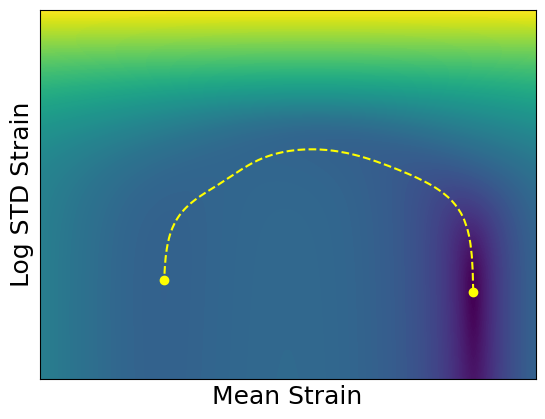

In [ ]:
cbar = plt.contourf(eps,taus,np.log10(aNeqs - np.min(aNeqs) + 0.01),cmap = "viridis",levels = 200)
#plt.colorbar(cbar)
plt.yscale("log")
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False,
    right = False,
    labelleft = False)

plt.plot(minFEeps,minFEtaus,color = "yellow",linestyle = "dashed")
plt.scatter([minFEeps[0],minFEeps[-1]],[minFEtaus[0],minFEtaus[-1]],color = "yellow",marker = "o")
plt.xlim([-2.,2.])
plt.ylim([0.01,10.])
plt.xlabel("Mean Strain",fontsize = 18)
plt.ylabel("Log STD Strain",fontsize = 18)
plt.savefig("Fig1A.png",dpi = 500)
plt.show()

### Change vairables to $\epsilon$ and $\Phi$.

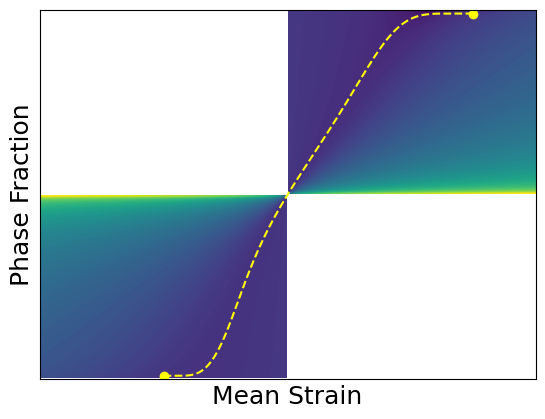

In [ ]:

minFEphis = cdf(minFEeps/minFEtaus)
minFEphis = 0.01 + .98*minFEphis  # linearly altered just to fit on the screen

eps = np.linspace(-2,2,200)
phis = np.linspace(0,1,200)
eps,phis = np.meshgrid(eps,phis)
aNeqs = vmap(AneqPhi,in_axes = (0,0,None))(eps.flatten(),phis.flatten(),BETA)
aNeqs = aNeqs.reshape(eps.shape)

cbar = plt.contourf(eps,phis,np.log10(aNeqs - np.min(aNeqs) + 0.01),cmap = "viridis",levels = 200)
#plt.colorbar(cbar)
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False,
    right = False,
    labelleft = False)
plt.plot(minFEeps,minFEphis,color = "yellow",linestyle = "dashed")
plt.scatter([minFEeps[0],minFEeps[-1]],[minFEphis[0],minFEphis[-1]],color = "yellow",marker = "o")
plt.xlabel("Mean Strain",fontsize = 18)
plt.ylabel("Phase Fraction",fontsize = 18)
plt.savefig("Fig1B.png",dpi = 500)
plt.show()

### Create the plot of the traditional free energy

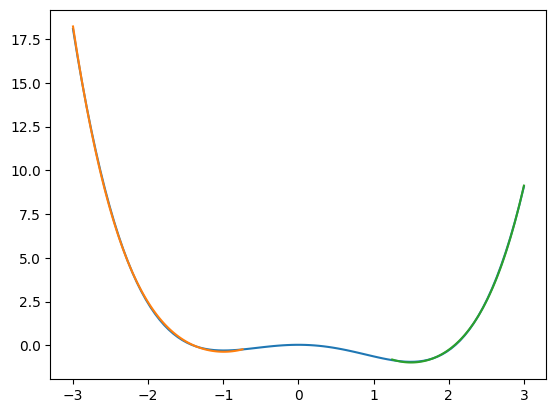

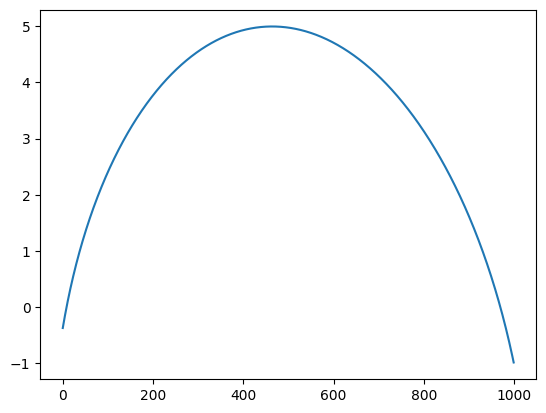

In [ ]:
lLeft = -minFEeps[-1]
lRight = minFEeps[0]
tauLeft = minFEtaus[-1]
tauRight = minFEtaus[0]


# Finding coefficients of for a quartic approximation of the Left and Right
# wells of the STIV non-equilibrium free energy

xL = np.linspace(-3.,-lLeft+.25,100) + lLeft
X = np.array([[x**i for i in [0,2,4]] for x in xL])
U,s,Vh = np.linalg.svd(X,full_matrices = False)
ys = vmap(Aneq,in_axes = (0,None,None))(xL - lLeft,tauLeft,BETA)
cL = Vh.conj().T @ np.diag(1/s) @ U.conj().T @ ys

xR = np.linspace(lRight -.25,3.,100) - lRight
X = np.array([[x**i for i in [0,2,4]] for x in xR])
U,s,Vh = np.linalg.svd(X,full_matrices = False)
ys = vmap(Aneq,in_axes = (0,None,None))(xR + lRight,tauRight,BETA)
cR = Vh.conj().T @ np.diag(1/s) @ U.conj().T @ ys


# Plotting the left well approximation in orange, the right well approximation
# in green and the true free energy in blue.

pnts = np.linspace(-3,3,100)
vals = vmap(Aneq,in_axes = (0,None,None))(pnts,tauLeft,BETA)
plt.plot(pnts,vals)
plt.plot(xL-lLeft,cL[0] + cL[1]*xL**2 + cL[2]*xL**4)
plt.plot(xR+lRight,cR[0] + cR[1]*xR**2 + cR[2]*xR**4)
plt.show()





def regFE(eps,phi,c = 1.):
    """
    The traditional free energy as a function of strain $\epsilon$
    and phase fraction $\phi$. c gives the strength of the phase fraction
    dependence c*phi*(1 - phi).

    eps - real number
    phi - real number in (0,1)
    c - positive real number

    return - real number
    """
    return (cL[0] + cL[1]*(eps + lLeft)**2 + cL[2]*(eps+lLeft)**4)*(1 - phi) + (cR[0] + cR[1]*(eps - lRight)**2 + cR[2]*(eps - lRight)**4)*phi + c*phi*(1 - phi)

def regFEinf(eps,phi,c=1.):
    """
    The traditional free energy, but strictly enforcing phi in (0,1). Using
    1000 in place of np.inf.

    eps - real number
    phi - real number in (0,1)
    c - positive real number

    return - real number
    """
    return cond(abs(2*phi - 1) < 1.,lambda n: regFE(eps,phi,c),lambda n: 1000.,None)


# for each phi in (0,1), find eps which minimizes the traditional free energy
# and make a plot of phi vs the minimum free energy for phi fixed.

c0 = 1.
regFEinf1 = lambda eps,phi: regFE(eps,phi,c = c0)

minFEphis1 = np.linspace(0,1,1000)
minFEeps1 = np.zeros_like(minFEphis1)
for i,p in enumerate(minFEphis1):
    es = np.linspace(-2,2,10000)
    vals = vmap(regFEinf1,in_axes = (0,None))(es,p)
    ind = np.where(vals == np.min(vals))[0][0]
    minFEeps1 = minFEeps1.at[i].set(es[ind])
vals = vmap(regFEinf1)(minFEeps1,minFEphis1)
plt.plot(vals)
plt.show()


eps = np.linspace(-2,2,200)
phis = np.linspace(0,1,200)
eps,phis = np.meshgrid(eps,phis)

aNeqs = regFE(eps.flatten(),phis.flatten(),c = 200.)
aNeqs = aNeqs.reshape(eps.shape)


### Plot the minimum free energy transition for the traditional free energy.

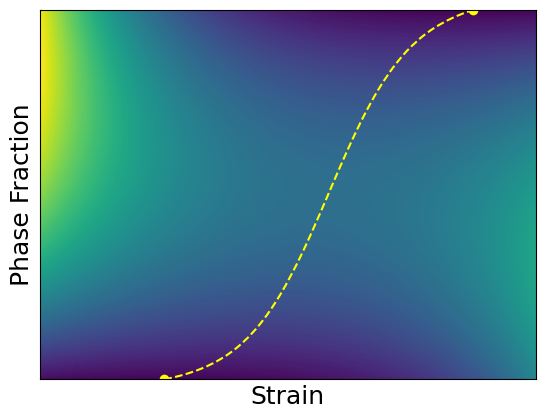

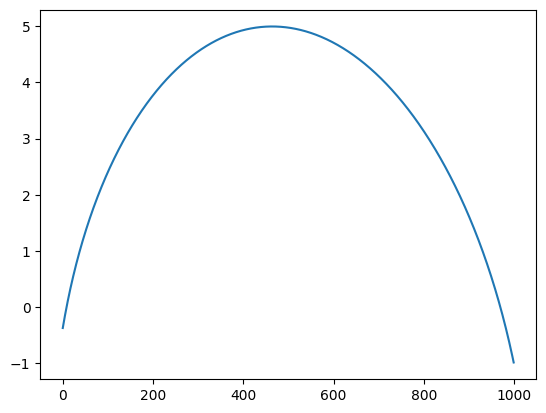

In [ ]:
plt.contourf(eps,phis,aNeqs,cmap = "viridis",levels = 200)
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False,
    right = False,
    labelleft = False)
plt.plot(minFEeps1,minFEphis1,color = "yellow",linestyle = "dashed")
plt.scatter([minFEeps1[0],minFEeps1[-1]],[minFEphis1[0],minFEphis1[-1]],color = "yellow",marker = "o")
plt.xlabel("Strain",fontsize = 18)
plt.ylabel("Phase Fraction",fontsize = 18)
plt.savefig("Fig1C.png",dpi = 500)
plt.show()